# Movie recommender

## Introduction

In this project we walk through the full processing of building our movie recommender.

This basic idea is to recommend movies based on the ranking of user's rating. The work mainly focuses on the following aspects:

1. Estimate user's movie rating by the average of K nearest neighbors and recommend by ratings' ranking.
2. Cluster movies to 3 groups by K-means and interpret each cluster by the top10 rated movies. 
3. Improve KNN by recommending movies in the same cluster.

## 1. Load data

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

In [8]:
data = pd.read_csv("data/movieReplicationSet.csv")

In [53]:
# There are 1097 users and 400 movies in our rating matrix.
data.shape

(1097, 400)

In [54]:
data.head()

,The Life of David Gale (2003),Wing Commander (1999),Django Unchained (2012),Alien (1979),Indiana Jones and the Last Crusade (1989),Snatch (2000),Rambo: First Blood Part II (1985),Fargo (1996),Let the Right One In (2008),Black Swan (2010),...,X-Men 2 (2003),The Usual Suspects (1995),The Mask (1994),Jaws (1975),Harry Potter and the Chamber of Secrets (2002),Patton (1970),Anaconda (1997),Twister (1996),MacArthur (1977),Look Who's Talking (1989)
0,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,0.5,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,4.0,...,NaN,3.0,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,3.5,NaN,0.5,NaN,0.5,1.0,NaN,0.0,...,2.5,NaN,3.0,NaN,NaN,NaN,NaN,1.5,NaN,NaN


## 2. Exploratory data analysis

In [55]:
# All rating values are numerical except for NaN
(data.dtypes != np.float64).sum()

0

In [117]:
# For each movie, there is at least one user who haven't watched it.
# So it is meaningful to recommend new movies for everyone.
(data.isna().sum() == 0).sum()

0

In [118]:
# For each movie, there is at least one user who have watched it.
# So it is possible that we get an estimate of users' rating for each movie.
data.isna().all().sum()

0

In [119]:
# Two users who have watched all 400 movies. 
# Their rating maybe important in recommending movies.
(data.isna().sum(axis = 1) == 0).sum()

2

In [122]:
# One user haven't watch any of the movies.
# So we know nothing about this user and can only drop this row.
data.isna().all(axis=1).sum()

1

In [127]:
# Drop the all NaN row
data.isna()[data.isna().all(axis=1)].index

Int64Index([896], dtype='int64')

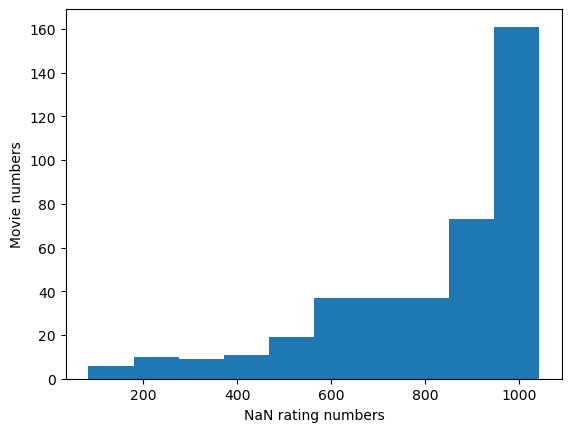

In [73]:
# Plot the distribution of NaN values' number for each movie
# The plot shows that: 
# Over 900 users have not watched half of movies. 
# So for these users a recommendation system is very necessary.
plt.hist(data.isnull().sum())
plt.xlabel('NaN rating numbers')
plt.ylabel('Movie numbers')
plt.show()

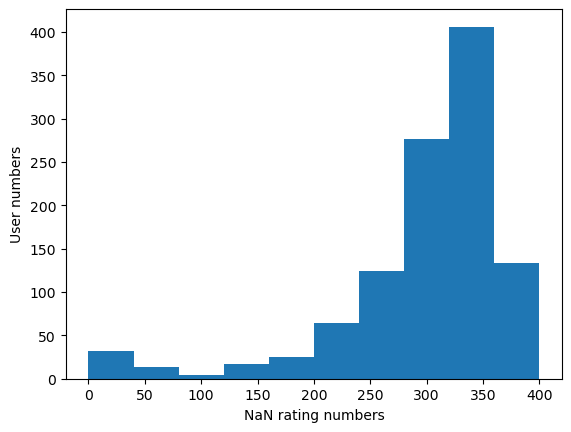

In [74]:
# Plot the distribution of NaN values' number for each user
# The plot shows that:
# 1. Most users have not watched half of the movies, which is consistent with our analysis above.
# 2. There are around 100 users who have watch most part of 400 movies. They can be good candidates for movie recommending.
plt.hist(data.isnull().sum(axis=1))
plt.xlabel('NaN rating numbers')
plt.ylabel('User numbers')
plt.show()

In [ ]:
df_movie_rating.isna()[df_movie_rating.isna().all(axis = 1)].index

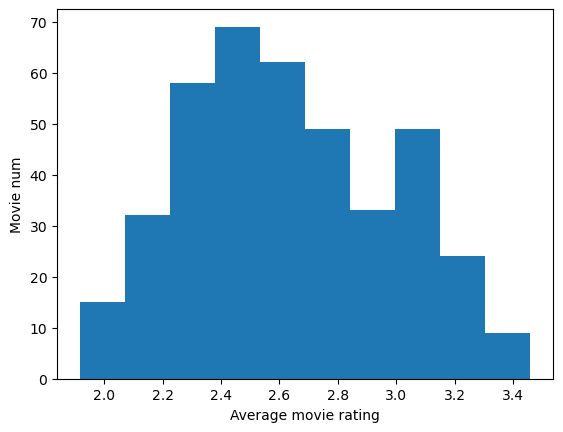

In [75]:
# Calculate average rating for each movie
# Plot histogram to see the distribution of average movie rating.
# By the plot below, we conclude that：
# 1. The distribution show a tendency of left-skewness. 
# 2. Extremely highly rated movies and lowly rated movies are rare. And most movies have moderate average rating. 
# 3. Some movie showing distinct higher average rating. This movies are probably good candidates for our further movie recommendation.
plt.hist(data.mean())
plt.xlabel('Average movie rating')
plt.ylabel('Movie num')
plt.show()

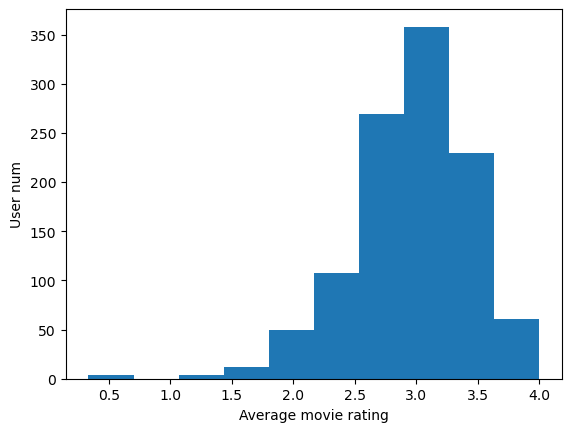

In [76]:
# Calculate average rating for each user
# Plot histogram to see the distribution of average users' rating.
# By the plot below, we conclude that：
# 1. Most users give average rating around 3, with some extremely low rating. 
# 2. This shows a potential pitfall for our Euclidean distance based model, because these users who gives extremely low rating may have tastes quite distinct with others.
plt.hist(data.mean(axis=1))
plt.xlabel('Average movie rating')
plt.ylabel('User num')
plt.show()

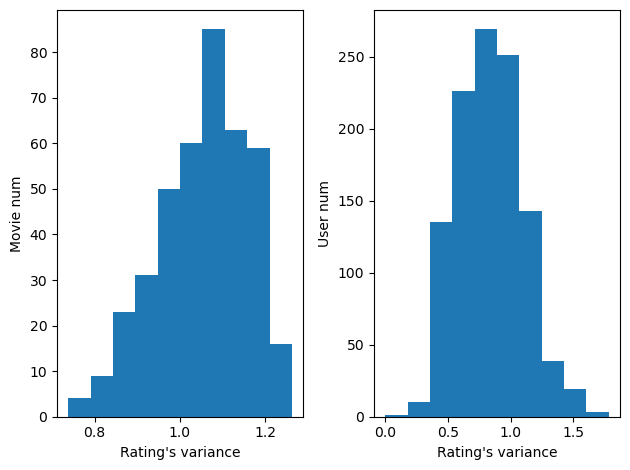

In [106]:
# Calculate ratings' standard deviation for each movie and histogram
# Plot histogram to see the distribution of ratings' variance.
# We can conclude from the plots below that the standard deviation is normally distributed.
fig, axs = plt.subplots(1, 2)
axs[0].hist(data.std())
axs[1].hist(data.std(axis=1))
axs[0].set_xlabel("Rating's variance")
axs[1].set_xlabel("Rating's variance")
axs[0].set_ylabel("Movie num")
axs[1].set_ylabel("User num")
fig.tight_layout()

## 3. KNN movie recommendation